In [8]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import snntorch as snn
import matplotlib.pyplot as plt

from utils import printf, load_data
from models import SimpleSNN, SimpleParaLif, LargerSNN
from scripts import test_model
from attacks import fgsm_attack

device = torch.device('mps')
# device = torch.device('cpu')

In [63]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1)
])

batch_size = 256

dataset = 'fashion'
fashion_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


train_dataset, train_loader = load_data(dataset, path='../data', batch_size=batch_size)
test_dataset, test_loader = load_data(dataset, path='../data', batch_size=batch_size, train=False)

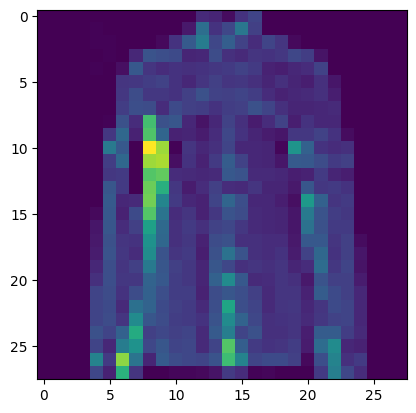

In [64]:
features, labels = next(iter(train_loader))
plt.imshow(features[0].permute(1,2,0) if dataset == 'cifar' else features[0,0])
plt.show()

# Loading Model

In [65]:
# ParaLIF
num_steps = 20
tau_mem = 0.02
tau_syn = 0.02
decay_rate = 0.
spike_mode = 'SB'

model = SimpleParaLif(28*28, device=device, spike_mode=spike_mode, num_steps=num_steps, tau_mem=tau_mem, tau_syn=tau_syn)

In [66]:
# model = SimpleSNN(3*32*32, num_steps=10).to(device)

state_dict = torch.load('models/' + dataset.upper() + '-SimpleParaLIF-5-epochs' + '.pt')
if isinstance(model, SimpleSNN) or isinstance(model, LargerSNN):
    state_dict = {k: v for k, v in state_dict.items() if 'mem' not in k}
    model.load_state_dict(state_dict, strict=False)
else:
    model.load_state_dict(state_dict)

# Evaluation

In [67]:
test_model(model, loader=test_loader, device=device)

0.8448

# Attacks

In [68]:
features, labels = next(iter(train_loader))
features, labels = features.to(device), labels.to(device)
perturbed, perturbed_output = fgsm_attack(model, nn.CrossEntropyLoss(), features, labels, epsilon=0.01)

In [70]:
model.eval()
predictions_on_perturbed = model(perturbed).argmax(dim=1)
predictions_on_originals = model(features).argmax(dim=1)

incorrect_indices = (predictions_on_perturbed != predictions_on_originals).nonzero().view(-1)
incorrect_indices

tensor([ 26,  33,  44,  52,  66,  69,  80,  82,  86,  98, 106, 131, 145, 147,
        154, 157, 171, 199, 204, 253], device='mps:0')

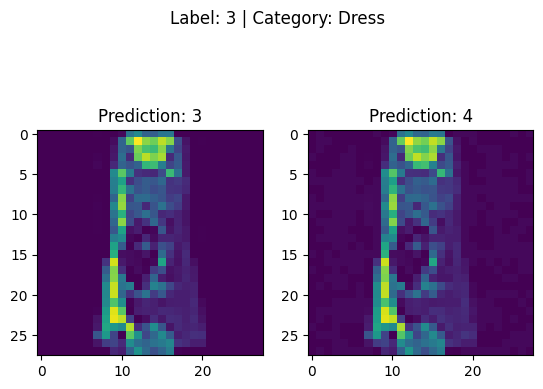

In [71]:
index = min(incorrect_indices)

fig, axs = plt.subplots(1,2)
axs[0].imshow(features[index, 0].detach().cpu())
axs[1].imshow(perturbed[index, 0].detach().cpu())
title = f" | Category: {fashion_categories[labels[index]]}"  if dataset == 'fashion' else ''
fig.suptitle(f'Label: {labels[index]}' + title)
axs[0].set_title(f'Prediction: {predictions_on_originals[index]}')
axs[1].set_title(f'Prediction: {predictions_on_perturbed[index]}')
plt.show()